# Exploratory data analysis - price


In this section, we will cover:

- Analysis of sample distribution
- Reducing skew
- Outliers
- Balancing the data

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import aux_functions as aux

In [2]:
# loading the data and testing our script
df_old = pd.read_csv('data/df_transformed.csv')
df = pd.read_csv('data/Auto1-DS-TestData.csv')
df = aux.clean_data(df)

for col_type in ['object', 'int64', 'float64']:
    test = (df.select_dtypes(col_type).describe() != df_old.select_dtypes(col_type).describe())
    if test.any().sum():
        print('not equal on ', col_type)
    else:
        print('all ok with', col_type)

all ok with object
all ok with int64
all ok with float64


## Analysis of sample distribution

The goal here is to understand what distribution the variable prices follow.

Also, understanding the behavior of the data is essential for building good prediction models.

In [3]:
df.price.describe()

count      193.000000
mean     13285.025907
std       8089.082886
min       5118.000000
25%       7738.000000
50%      10245.000000
75%      16515.000000
max      45400.000000
Name: price, dtype: float64

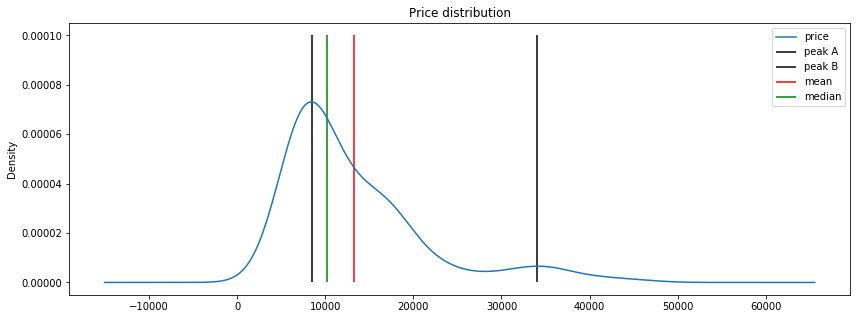

In [4]:
figsize = (14, 5)
df.price.plot(kind='kde', legend=True, figsize=figsize, title='Price distribution')
plt.vlines(8500, 0, .0001, label='peak A')
plt.vlines(34000, 0, .0001, label='peak B')
plt.vlines(df.price.mean(), 0, .0001, color='r', label='mean')
plt.vlines(df.price.median(), 0, .0001, color='g', label='median')
plt.legend()

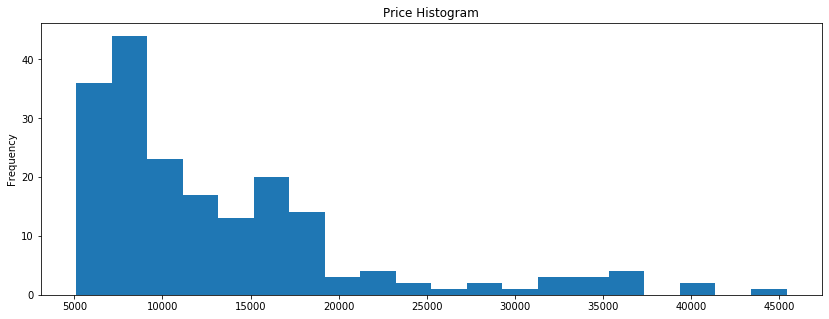

In [5]:
df.price.plot(kind='hist', figsize=figsize, bins=20, title='Price Histogram')

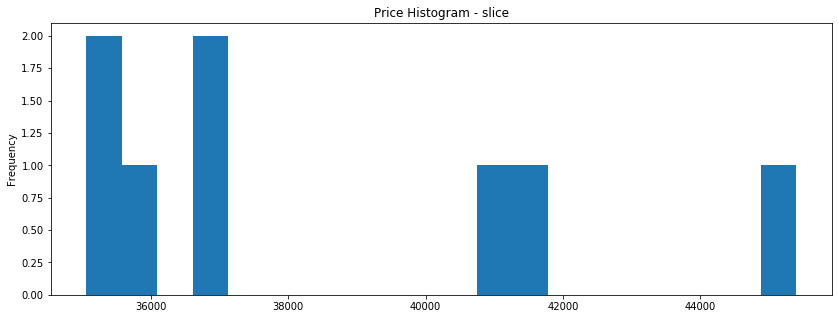

In [6]:
mask = df.price > 35000
df.price[mask].plot(kind='hist', figsize=figsize, bins=20, title='Price Histogram - slice')

In [7]:
mask = df.price > 40000
df.price[mask]

16    41315.0
73    40960.0
74    45400.0
Name: price, dtype: float64

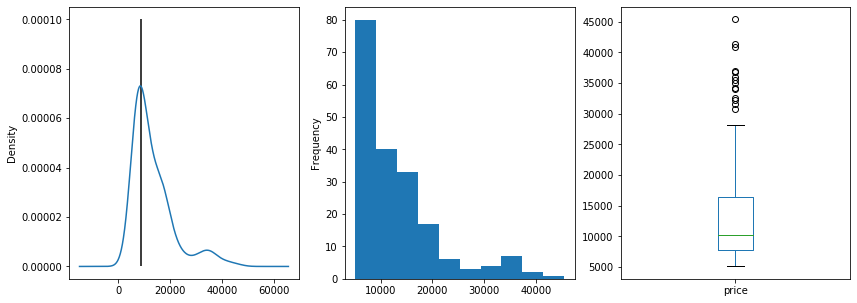

In [8]:
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, sharey=False)

figsize = (14, 5)
df.price.plot(kind='kde', legend=False, ax=ax,  figsize=figsize)
ax.vlines(8500, 0, .0001, label='peak A')
df.price.plot(kind='hist',ax=ax2, figsize=figsize)
df.price.plot(kind='box', legend=False, ax=ax3, figsize=figsize)
plt.show()

In [9]:
# checking outliers through number of observations
df['price_cats'] = pd.cut(df.price, bins=20)
df['price_cats'].value_counts().sort_values()

(37343.6, 39357.7]     0
(41371.8, 43385.9]     0
(43385.9, 45400.0]     1
(29287.2, 31301.3]     1
(25259.0, 27273.1]     1
(39357.7, 41371.8]     2
(27273.1, 29287.2]     2
(23244.9, 25259.0]     2
(31301.3, 33315.4]     3
(33315.4, 35329.5]     3
(19216.7, 21230.8]     3
(35329.5, 37343.6]     4
(21230.8, 23244.9]     4
(13174.4, 15188.5]    13
(17202.6, 19216.7]    14
(11160.3, 13174.4]    17
(15188.5, 17202.6]    20
(9146.2, 11160.3]     23
(5077.718, 7132.1]    36
(7132.1, 9146.2]      44
Name: price_cats, dtype: int64

In [10]:
top_wisker = df.price.quantile(.75) + 1.5*(df.price.quantile(.75) - df.price.quantile(.25))
print(f'Wisker upper: {top_wisker}')

# prob for y > top_wisker
import scipy.stats as st
prob = 1 - st.norm.cdf(top_wisker, df.price.mean(), df.price.std())
print(f'prob for y > top_wisker: {prob:.3}')
      
#99% quantile
qt = st.norm.ppf(.99, df.price.mean(), df.price.std()) # just exploring
print(f'99% quantile: {qt:4.3}')
      
# prob for prices bellow 32k
prob = st.norm.cdf(32000, df.price.mean(), df.price.std()) # just exploring
print(f'prob for prices bellow 32k: {prob:.3}')

Wisker upper: 29680.5
prob for y > top_wisker: 0.0213
99% quantile: 3.21e+04
prob for prices bellow 32k: 0.99


Important characteristics of the prices distribution:

- mean: \\$13285.02
- median: \\$10245.00
- standard deviation: \\$8089.08
- range: \\$40282.00

The prices distribution is bimodal with peaks around \\$8500.00 and \\$34000.00. However, in this study we will consider that this happens due to data skew.

The prices go from \\$5118.00 to \\$45400.00.


## Discussion about outliers


Prices above \\$38000.00 have only 03 observations. While it is very tempting to call them outliers, this is not really the case. We have sales at

- \\$41315.00
- \\$40960.00
- \\$45400.00

As those prices are in the same level as the prices of the regular sales, it becomes clear that they are not recorded by mistake. Those observations are just really rare on this sample.

If there was outliers among the observations we would remove them because outliers could be highly influential points and could leverage predictive models.

## Log transformation on prices

As we saw in data analysis, the price variable has a really wide range and its highly skewed. Linear regression predictive algorithms will have some trouble, sometimes even predicting negative prices.

To better understand the patterns of the data and the correlation between the variable price and the independent variables, we will apply a log transformation on prices.

This transformation reshapes the distribution reducing its skewness.


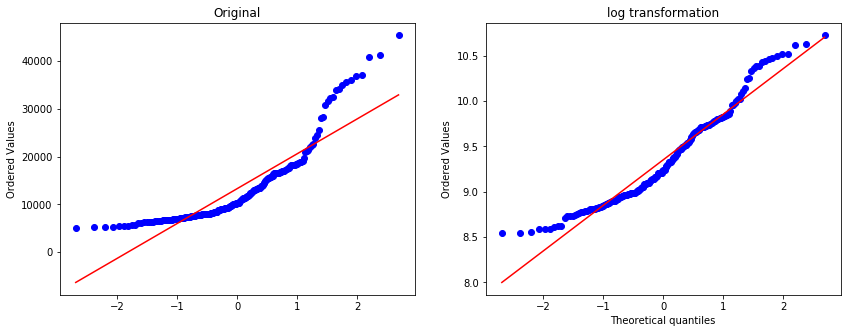

In [11]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax, ax1) = plt.subplots(ncols=2, sharey=False, figsize=figsize)

prob = stats.probplot(df.price, dist=stats.norm, plot=ax)
ax.set_xlabel('')
ax.set_title('Original')

df['log_price'] = np.log(df.price)
prob = stats.probplot(df['log_price'], dist=stats.norm, plot=ax1)
ax1.set_title('log transformation')

plt.show()

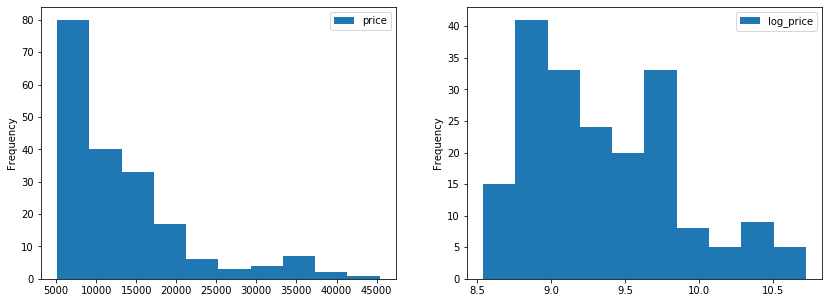

In [12]:
fig, (ax, ax1) = plt.subplots(ncols=2, sharey=False)
df.price.plot(kind='hist', legend=True, ax=ax, figsize=figsize)
df.log_price.plot(kind='hist', legend=True, ax=ax1, figsize=figsize)

plt.show()

## Balancing the data

### Splitting cars in classes according to its price

Just to take a look into the distribution of prices and into the samples available for each price range, lets define car classes according to price ranges:

In [13]:
labels = [
    'almost-free', 'super-cheap', 'cheap',
    'normal', 'expensive', 'super-expensive'
]
df["class_range"] = pd.cut(df.price, 6, labels=labels)
df.groupby('class_range')[['price']].min() # starting prices for each class

,price
class_range,
almost-free,5118.0
super-cheap,11850.0
cheap,18620.0
normal,25552.0
expensive,32250.0
super-expensive,40960.0


In [14]:
df.class_range.value_counts()

almost-free        110
super-cheap         53
cheap               13
expensive            9
normal               5
super-expensive      3
Name: class_range, dtype: int64

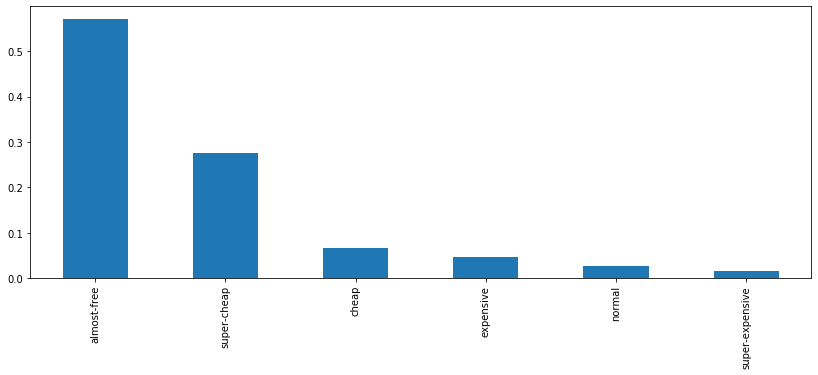

In [15]:
df.class_range.value_counts(normalize=True).plot.bar(figsize=figsize)

### Balancing the data: bootstrap

Our dataset has only 197 observations and some price ranges are not well represented here.
We will fix this balance issue through bootstrap: lets get more samples for each price range through bootstrap:

In [16]:
df_old = df.copy()
df = df.sample(10000, replace=True)
df.shape

(10000, 28)

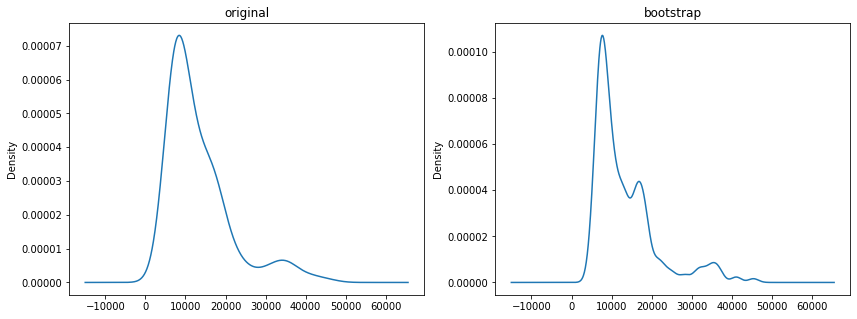

In [17]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=figsize)

df_old.price.plot(kind='kde', legend=False, ax=ax, title="original")
df.price.plot(kind='kde',ax=ax2, title="bootstrap")
plt.show()

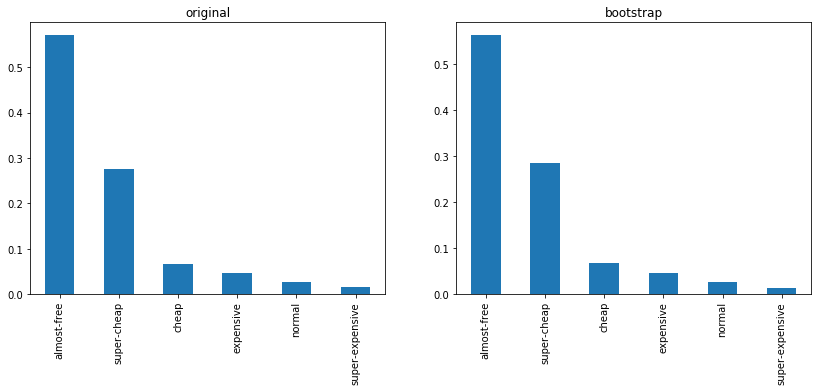

In [18]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=figsize)
df_old.class_range.value_counts(normalize=True).plot.bar(ax=ax, title='original')
df.class_range.value_counts(normalize=True).plot.bar(ax=ax2, title='bootstrap')

In [19]:
print(
    'original\n',
    df.class_range.value_counts(normalize=True),
    '\n#########\n',
    'bootstrap\n',
    df_old.class_range.value_counts(normalize=True)
)

original
 almost-free        0.5617
super-cheap        0.2856
cheap              0.0666
expensive          0.0469
normal             0.0267
super-expensive    0.0125
Name: class_range, dtype: float64 
#########
 bootstrap
 almost-free        0.569948
super-cheap        0.274611
cheap              0.067358
expensive          0.046632
normal             0.025907
super-expensive    0.015544
Name: class_range, dtype: float64


## Conclusion

From this brief analysis about prices, we found out:

- the distribution is not normal - could be bimodal as well
- there are outliers and we have removed them
- a log transformation on prices would be useful for linear models, since it reduces the skewness in prices distribution
- there is no balance on price ranges: we addressed that through bootstrap.

In [20]:
df.drop(['log_price', 'class_range', 'price_cats'], axis=1).to_csv('data/df_resample.csv', index=False)